Actividad integradora 2 - Parte 1: Redes de conectividad en el cerebro humano

Equipo 5
Erick Eduardo Orozco Reyes - A01198247
Herbert Eduardo Euroza Hernández - A01635175
Carlos Dhali Tejeda Tapia - A00344820

Librerias que se usarán a lo largo del proyecto

In [30]:
import numpy as np
import matplotlib.pyplot as plt

from queue import Queue
from queue import LifoQueue
from queue import PriorityQueue

import networkx as nx
import math
from math import atan2

import matplotlib as mpl
import matplotlib.cm as cm

from scipy.spatial import Voronoi, voronoi_plot_2d

Clases que se usarán a lo largo del proyecto

In [31]:
def distance(xA, yA, zA, xB, yB, zB):
    punto1 = np.array([xA, yA, zA])
    punto2 = np.array([xB, yB, zB])
    distance = np.linalg.norm(punto2 - punto1)
    return distance

In [32]:
class WeightedGraph:
    """
    Representación de un grafo ponderado.
    Utiliza una lista de adyacencia para almacenar vértices y aristas.
    La lista es un diccionario cuyas claves representan los vértices.
    Cada vértice en el diccionario tiene una lista de tuplas, donde cada tupla
    representa un vértice vecino y su peso.
    El grafo puede ser dirigido o no dirigido.
    """

    _directed = True
    _adjacency_list = {}  # Lista de adyacencia

    def __init__(self, directed: bool = False):
        """
        Inicializa un grafo vacío.

        :param directed: Un indicador que indica si el grafo es dirigido (True) o no dirigido (False).
        """
        self._directed = directed
        self._adjacency_list = {}

    def clear(self):
        """Limpia la lista de adyacencia."""
        self._adjacency_list = {}

    def number_of_vertices(self):
        """Devuelve el número de vértices en el grafo."""
        return len(self._adjacency_list)

    def vertices(self):
        """Devuelve una lista de vértices en el grafo."""
        return list(self._adjacency_list.keys())

    def edges(self):
        """Devuelve una lista de aristas en el grafo."""
        edges = []
        for v in self._adjacency_list:
            for neighbor, weight in self._adjacency_list[v]:
                if self._directed or (neighbor, v, weight) not in edges:
                    edges.append((v, neighbor, weight))
        return edges

    def add_vertex(self, v):
        """Añade un vértice al grafo."""
        if v not in self._adjacency_list:
            self._adjacency_list[v] = []

    def remove_vertex(self, v):
        """Elimina un vértice del grafo."""
        if v in self._adjacency_list:
            del self._adjacency_list[v]
            for vertex in self._adjacency_list:
                self._adjacency_list[vertex] = [(u, w) for u, w in self._adjacency_list[vertex] if u != v]

    def add_edge(self, v1, v2, e=0):
        """Añade una arista al grafo."""
        if v1 in self._adjacency_list and v2 in self._adjacency_list:
            if (v2, e) not in self._adjacency_list[v1]:
                self._adjacency_list[v1].append((v2, e))
                if not self._directed:
                    self._adjacency_list[v2].append((v1, e))

    def remove_edge(self, v1, v2, e):
        """Elimina una arista del grafo."""
        if v1 in self._adjacency_list and v2 in self._adjacency_list:
            self._adjacency_list[v1] = [(u, w) for u, w in self._adjacency_list[v1] if u != v2 or w != e]
            if not self._directed:
                self._adjacency_list[v2] = [(u, w) for u, w in self._adjacency_list[v2] if u != v1 or w != e]

    def adjacent_vertices(self, v):
        """Devuelve la lista de vértices adyacentes a un vértice dado."""
        return self._adjacency_list.get(v, [])

    def is_adjacent(self, v1, v2) -> bool:
        """Comprueba si v2 es adyacente a v1."""
        return any(u == v2 for u, _ in self._adjacency_list.get(v1, []))

    def graficasGraph(self, matrix_file, coordinates_file):
        """Carga un grafo desde archivos de matriz y coordenadas."""
        print(matrix_file)
        matrix = np.loadtxt(matrix_file, dtype=int)
        coordinates = np.loadtxt(coordinates_file, dtype=str)

        for i in range(len(coordinates)):
            self.add_vertex(coordinates[i][0])

        for i in range(len(coordinates)):
            for x in range(len(matrix[i])):
                if matrix[i][x] == 1 and not self.is_adjacent(coordinates[i][0], coordinates[x][0]):
                    cost = distance(float(coordinates[i][1]), float(coordinates[i][2]), float(coordinates[i][3]),
                                    float(coordinates[x][1]), float(coordinates[x][2]), float(coordinates[x][3]))
                    self.add_edge(coordinates[i][0], coordinates[x][0], cost)

        self.print_graph()

    def print_graph(self):
        """Muestra las aristas del grafo."""
        for vertex in self._adjacency_list:
            for neighbor, weight in self._adjacency_list[vertex]:
                print(vertex, " -> ", neighbor, " peso ", weight)


class TreeNode:
    """
    Representa un nodo en un árbol.
    Cada nodo tiene un padre, un vértice del grafo que representa y un costo de camino desde la raíz.
    """

    def __init__(self, parent, v, c):
        """
        Inicializa un nodo.

        :param parent: El nodo padre.
        :param v: El vértice del grafo representado por el nodo.
        :param c: El costo del camino al nodo desde la raíz.
        """
        self.parent = parent
        self.v = v
        self.c = c

    def path(self):
        """Crea la lista de vértices desde la raíz hasta el nodo."""
        node = self
        path = []
        while node is not None:
            path.insert(0, node.v)  # Insertar en la posición 0 para construir el camino desde la raíz.
            node = node.parent
        return path

    def __lt__(self, other):
        # Implementa la comparación para que PriorityQueue pueda ordenar los nodos por costo
        return self.c < other.c


class GraphFloyd:
    """
    Representa un grafo para el algoritmo de Floyd-Warshall.
    """

    def __init__(self, directed: bool = False):
        self._directed = directed
        self._vertices = []
        self._adjacency_matrix = []

    def add_vertex(self, v):
        """Añade un vértice al grafo."""
        if v not in self._vertices:
            self._vertices.append(v)
            n = len(self._vertices)
            if n > 1:
                for vertex in self._adjacency_matrix:
                    vertex.append(0)
            self._adjacency_matrix.append(n * [0])

    def remove_vertex(self, v):
        """Elimina un vértice del grafo."""
        if v in self._vertices:
            index = self._vertices.index(v)
            self._vertices.pop(index)
            for row in self._adjacency_matrix:
                row.pop(index)
            self._adjacency_matrix.pop(index)

    def add_edge(self, v1, v2, e=0):
        """Añade una arista al grafo."""
        if v1 in self._vertices and v2 in self._vertices:
            index1 = self._vertices.index(v1)
            index2 = self._vertices.index(v2)
            self._adjacency_matrix[index1][index2] = e
            if not self._directed:
                self._adjacency_matrix[index2][index1] = e

    def remove_edge(self, v1, v2):
        """Elimina una arista del grafo."""
        if v1 in self._vertices and v2 in self._vertices:
            index1 = self._vertices.index(v1)
            index2 = self._vertices.index(v2)
            self._adjacency_matrix[index1][index2] = 0
            if not self._directed:
                self._adjacency_matrix[index2][index1] = 0

    def is_adjacent(self, v1, v2) -> bool:
        """Comprueba si v2 es adyacente a v1."""
        if v1 in self._vertices and v2 in self._vertices:
            i = self._vertices.index(v1)
            j = self._vertices.index(v2)
            return self._adjacency_matrix[i][j] != 0
        return False

    def graficasGraph(self, matrix_file, coordinates_file):
        """Carga un grafo desde archivos de matriz y coordenadas."""
        print(matrix_file)
        matrix = np.loadtxt(matrix_file, dtype=int)
        coordinates = np.loadtxt(coordinates_file, dtype=str)

        for i in range(len(coordinates)):
            self.add_vertex(coordinates[i][0])

        for i in range(len(coordinates)):
            for x in range(len(matrix[i])):
                if matrix[i][x] == 1 and not self.is_adjacent(coordinates[i][0], coordinates[x][0]):
                    cost = distance(float(coordinates[i][1]), float(coordinates[i][2]), float(coordinates[i][3]),
                                    float(coordinates[x][1]), float(coordinates[x][2]), float(coordinates[x][3]))
                    self.add_edge(coordinates[i][0], coordinates[x][0], cost)

        self.print_graph()

    def print_graph(self):
        """Muestra las aristas del grafo."""
        n = len(self._vertices)
        for i in range(n):
            for j in range(n):
                if self._adjacency_matrix[i][j] != 0:
                    print(self._vertices[i], " -> ", self._vertices[j], " edge weight: ", self._adjacency_matrix[i][j])


Funciones de gráficación

In [33]:
def convertir_3d_a_2d(points3D):
    """
    Convierte coordenadas 3D a 2D utilizando proyección estereográfica.

    :param points3D: Array de puntos 3D, cada punto representado como (x, y, z).
    :return: Array de puntos 2D, cada punto representado como (x, y).
    """
    r = np.sqrt(points3D[:, 0]**2 + points3D[:, 1]**2 + points3D[:, 2]**2)
    t = r / (r + points3D[:, 2])
    x = r * points3D[:, 0]
    y = r * points3D[:, 1]
    return np.column_stack((x, y))

def graficar_puntos_2d(points2D, channels):
    """
    Grafica puntos en 2D y agrega etiquetas con los nombres de los canales.

    :param points2D: Array de puntos 2D, cada punto representado como (x, y).
    :param channels: Lista de nombres de canales correspondientes a cada punto.
    """
    circle = plt.Circle((0, 0), 1, color='r', alpha=0.25, fill=False)
    plt.scatter(points2D[:, 0], points2D[:, 1])
    plt.gca().add_patch(circle)

    for i in range(len(points2D)):
        plt.text(points2D[i, 0] - 0.02, points2D[i, 1] + 0.025, channels[i])

def graficar_aristas_2d(points2D, channels, graph):
    """
    Grafica aristas en 2D conectando los puntos correspondientes a los vértices y agrega etiquetas de canales.

    :param points2D: Array de puntos 2D, cada punto representado como (x, y).
    :param channels: Lista de nombres de canales correspondientes a cada punto.
    :param graph: Grafo ponderado con información de las aristas.
    """
    for vertex in channels:
        neighbors = graph.adjacent_vertices(vertex)
        if len(neighbors) == 0:
            continue
        for neighbor, weight in neighbors:
            v_index = channels.index(vertex)
            n_index = channels.index(neighbor)
            plt.plot([points2D[v_index, 0], points2D[n_index, 0]],
                     [points2D[v_index, 1], points2D[n_index, 1]],
                     color='blue', linestyle='--', linewidth=2)

def generar_puntos_3d(conjunto_electrodos="8"):
    """
    Genera puntos 3D para electrodos.

    :param conjunto_electrodos: Una cadena que especifica el conjunto de electrodos ("8" o "32").
    :return: Un array de NumPy que contiene los puntos 3D.
    """
    if conjunto_electrodos == "8":
        return np.array([[0, 0.71934, 0.694658],
                         [-0.71934, 0, 0.694658],
                         [0, 0, 1],
                         [0.71934, 0, 0.694658],
                         [0, -0.71934, 0.694658],
                         [-0.587427, -0.808524, -0.0348995],
                         [0, -0.999391, -0.0348995],
                         [0.587427, -0.808524, -0.0348995]])
    elif conjunto_electrodos == "32":
        return np.array([[-0.308829, 0.950477, -0.0348995],
                     [0.308829, 0.950477, -0.0348995],
                     [-0.406247, 0.871199, 0.275637],
                     [0.406247, 0.871199, 0.275637],
                     [-0.808524, 0.587427, -0.0348995],
                     [-0.545007, 0.673028, 0.5],
                     [0, 0.71934, 0.694658],
                     [0.545007, 0.673028, 0.5],
                     [0.808524, 0.587427, -0.0348995],
                     [-0.887888, 0.340828, 0.309017],
                     [-0.37471, 0.37471, 0.848048],
                     [0.37471, 0.37471, 0.848048],
                     [0.887888, 0.340828, 0.309017],
                     [-0.999391, 0, -0.0348995],
                     [-0.71934, 0, 0.694658],
                     [0, 0, 1],
                     [0.71934, 0, 0.694658],
                     [0.999391, 0, -0.0348995],
                     [-0.887888, -0.340828, 0.309017],
                     [-0.37471, -0.37471, 0.848048],
                     [0.37471, -0.37471, 0.848048],
                     [0.887888, -0.340828, 0.309017],
                     [-0.808524, -0.587427, -0.0348995],
                     [-0.545007, -0.673028, 0.5],
                     [0, -0.71934, 0.694658],
                     [0.545007, -0.673028, 0.5],
                     [0.808524, -0.587427, -0.0348995],
                     [-0.406247, -0.871199, 0.275637],
                     [0.406247, -0.871199, 0.275637],
                     [-0.308829, -0.950477, -0.0348995],
                     [0, -0.999391, -0.0348995],
                     [0.308829, -0.950477, -0.0348995]])

def graficarGrafos(conjunto_electrodos="8", grafica=WeightedGraph):
    """
    Grafica la representación 2D de los puntos de electrodos y las aristas en el grafo.

    :param conjunto_electrodos: Una cadena que especifica el conjunto de electrodos ("8" o "32").
    :param grafica: Una instancia de la clase WeightedGraph.
    """
    if conjunto_electrodos not in ["8", "32"]:
        print("Error: El conjunto de electrodos debe ser '8' o '32'")
        return

    canales_8 = ['Fz', 'C3', 'Cz', 'C4', 'Pz', 'PO7', 'Oz', 'PO8']
    canales_32 = ['Fp1', 'Fp2', 'AF3', 'AF4', 'F7', 'F3', 'Fz', 'F4', 'F8', 'FC5', 'FC1', 'FC2', 'FC6', 'T7', 'C3', 'Cz',
                  'C4', 'T8', 'CP5', 'CP1', 'CP2', 'CP6', 'P7', 'P3', 'Pz', 'P4', 'P8', 'PO3', 'PO4', 'O1', 'Oz', 'O2']

    # Genera puntos 3D y los convierte a 2D
    puntos_3D = generar_puntos_3d(conjunto_electrodos)
    puntos_2D = convertir_3d_a_2d(puntos_3D)

    # Grafica los puntos 2D y las aristas
    graficar_puntos_2d(puntos_2D, canales_8 if conjunto_electrodos == "8" else canales_32)
    graficar_aristas_2d(puntos_2D, canales_8 if conjunto_electrodos == "8" else canales_32, grafica)

    plt.axis('equal')
    plt.show()

Etapa 1

Grafica todos los grafos de conectividad que obtuviste en 2D

In [34]:
import numpy as np
import matplotlib.pyplot as plt


def graficasCaminos8(caminos):
    channels = ['Fz', 'C3', 'Cz', 'C4', 'Pz', 'PO7', 'Oz', 'PO8']

    points3D = [[0, 0.71934, 0.694658], [-0.71934, 0, 0.694658], [0, 0, 1], [0.71934, 0, 0.694658],
                [0, -0.71934, 0.694658], [-0.587427, -0.808524, -0.0348995], [0, -0.999391, -0.0348995],
                [0.587427, -0.808524, -0.0348995]]
    points3D = np.array(points3D)

    r = np.sqrt(points3D[:, 0] ** 2 + points3D[:, 1] ** 2 + points3D[:, 2] ** 2)
    t = r / (r + points3D[:, 2])
    x = r * points3D[:, 0]
    y = r * points3D[:, 1]
    points2D = np.column_stack((x, y))

    circle = plt.Circle((0, 0), 1, color='r', alpha=0.25, fill=False)
    plt.scatter(points2D[:, 0], points2D[:, 1])
    plt.gca().add_patch(circle)

    for i in range(len(points2D)):
        plt.text(points2D[i, 0] - 0.02, points2D[i, 1] + 0.025, channels[i])

    index = []

    for x in caminos:
        index.append(channels.index(x))

    print("index : ", index)

    # Resaltar la aristas

    for i in range(len(index) - 1):
        plt.plot([points2D[index[i], 0], points2D[index[i + 1], 0]],
                 [points2D[index[i], 1], points2D[index[i + 1], 1]],
                 color='blue', linestyle='--', linewidth=2)

    plt.axis('equal')
    plt.show()

def graficasCaminos32(caminos):
    channels = ['Fp1', 'Fp2', 'AF3', 'AF4', 'F7', 'F3', 'Fz', 'F4', 'F8', 'FC5', 'FC1', 'FC2', 'FC6', 'T7', 'C3', 'Cz',
                'C4', 'T8', 'CP5', 'CP1', 'CP2', 'CP6', 'P7', 'P3', 'Pz', 'P4', 'P8', 'PO3', 'PO4', 'O1', 'Oz', 'O2']

    points3D = [[-0.308829, 0.950477, -0.0348995], [0.308829, 0.950477, -0.0348995], [-0.406247, 0.871199, 0.275637],
                [0.406247, 0.871199, 0.275637], [-0.808524, 0.587427, -0.0348995], [-0.545007, 0.673028, 0.5],
                [0, 0.71934, 0.694658], [0.545007, 0.673028, 0.5], [0.808524, 0.587427, -0.0348995],
                [-0.887888, 0.340828, 0.309017], [-0.37471, 0.37471, 0.848048], [0.37471, 0.37471, 0.848048],
                [0.887888, 0.340828, 0.309017], [-0.999391, 0, -0.0348995], [-0.71934, 0, 0.694658], [0, 0, 1],
                [0.71934, 0, 0.694658], [0.999391, 0, -0.0348995], [-0.887888, -0.340828, 0.309017],
                [-0.37471, -0.37471, 0.848048], [0.37471, -0.37471, 0.848048], [0.887888, -0.340828, 0.309017],
                [-0.808524, -0.587427, -0.0348995], [-0.545007, -0.673028, 0.5], [0, -0.71934, 0.694658],
                [0.545007, -0.673028, 0.5], [0.808524, -0.587427, -0.0348995], [-0.406247, -0.871199, 0.275637],
                [0.406247, -0.871199, 0.275637], [-0.308829, -0.950477, -0.0348995], [0, -0.999391, -0.0348995],
                [0.308829, -0.950477, -0.0348995]]
    points3D = np.array(points3D)

    r = np.sqrt(points3D[:, 0] ** 2 + points3D[:, 1] ** 2 + points3D[:, 2] ** 2)
    t = r / (r + points3D[:, 2])
    x = r * points3D[:, 0]
    y = r * points3D[:, 1]
    points2D = np.column_stack((x, y))

    circle = plt.Circle((0, 0), 1, color='r', alpha=0.25, fill=False)
    plt.scatter(points2D[:, 0], points2D[:, 1])
    plt.gca().add_patch(circle)

    for i in range(len(points2D)):
        plt.text(points2D[i, 0] - 0.02, points2D[i, 1] + 0.025, channels[i])

    index = []
    for x in caminos:
        index.append(channels.index(x))

    # Resaltar la arista entre Fz y PO8
    for i in range(len(index) - 1):
        plt.plot([points2D[index[i], 0], points2D[index[i + 1], 0]],
                 [points2D[index[i], 1], points2D[index[i + 1], 1]],
                 color='blue', linestyle='--', linewidth=2)

    plt.axis('equal')
    plt.show()

Llamada a funciones de Etapa 1

index :  []


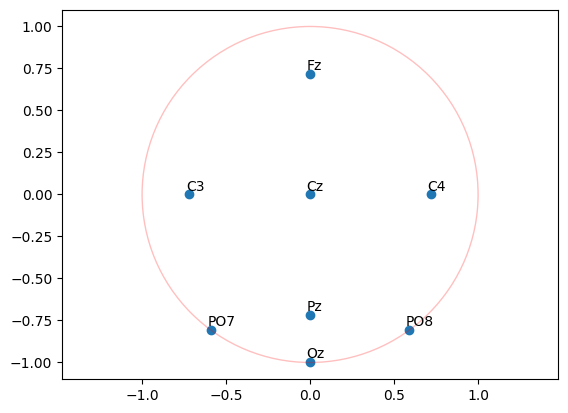

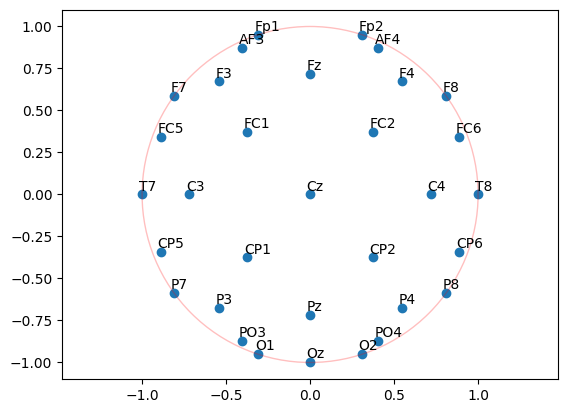

In [35]:
arreglograficas = []

graficasCaminos8(arreglograficas)

graficasCaminos32(arreglograficas)

Etapa 2 - Análisis de caminos en los grafos de conectividad

Convierte todos tus grafos no ponderados a grafos ponderados utilizando como pesos las distancias físicas que hay entre electrodos (ver tablas de posiciones 3D).

In [36]:
grafo1 = WeightedGraph(directed=False)
grafo2 = WeightedGraph(directed=False)
grafo3 = WeightedGraph(directed=False)
grafo4 = WeightedGraph(directed=False)

grafo1.graficasGraph('Operaciones_Dhali.txt', '8elec.txt')
grafo2.graficasGraph('Lectura_S0A.txt', '32elec.txt')

grafo1.print_graph
grafo2.print_graph

Operaciones_Dhali.txt
Fz  ->  Cz  peso  0.7814625855176945
C3  ->  Cz  peso  0.7814625855176945
C3  ->  Pz  peso  1.0173003839574621
C3  ->  PO7  peso  1.0969805121109717
Cz  ->  Fz  peso  0.7814625855176945
Cz  ->  C3  peso  0.7814625855176945
Cz  ->  C4  peso  0.7814625855176945
Cz  ->  Pz  peso  0.7814625855176945
C4  ->  Cz  peso  0.7814625855176945
C4  ->  Pz  peso  1.0173003839574621
Pz  ->  C3  peso  1.0173003839574621
Pz  ->  Cz  peso  0.7814625855176945
Pz  ->  C4  peso  1.0173003839574621
Pz  ->  PO7  peso  0.9408923487792055
Pz  ->  Oz  peso  0.7814619046423504
Pz  ->  PO8  peso  0.9408923487792055
PO7  ->  C3  peso  1.0969805121109717
PO7  ->  Pz  peso  0.9408923487792055
PO7  ->  Oz  peso  0.617657422863192
PO7  ->  PO8  peso  1.174854
Oz  ->  Pz  peso  0.7814619046423504
Oz  ->  PO7  peso  0.617657422863192
Oz  ->  PO8  peso  0.617657422863192
PO8  ->  Pz  peso  0.9408923487792055
PO8  ->  PO7  peso  1.174854
PO8  ->  Oz  peso  0.617657422863192
Lectura_S0A.txt
Fp1  ->  A

<bound method WeightedGraph.print_graph of <__main__.WeightedGraph object at 0x7ee3bc65e0b0>>


Para los grafos obtenidos con el dispositivo Unicorn, utiliza el método de BFS para encontrar caminos entre los siguientes pares de electrodos:

Fz - PO8
C3 - Oz
P07 - C4
Otras 2 parejas inventadas por el equipo.
Fz - C3
PO8 - Oz

Funciones necesarias para este paso:

In [37]:
# Funciones para obtener los caminos
def bfs(graph: WeightedGraph, v0, vg):
    # Recorrido en anchura (Breadth-first), de v0 a vg
    # Regresa una tupla con el camino de vi a vg y el costo, en caso de no existir regresa null

    # Checar si los vrtices no existen
    if v0 not in graph.vertices():
        print("ALERTA;--- vertex ", v0, " no existe")

    if vg not in graph.vertices():
        print("ALERTA -  vertice ", vg, " no existe")

    # Inicializar frontera
    frontier = Queue()
    frontier.put(TreeNode(None, v0, 0))

    # Inicialilzar set de exploracion
    explored_set = {}

    while True:
        if frontier.empty():
            return None

        node = frontier.get()

        # Checar si el nodo es el destino
        if node.v == vg:
            return {"Path": node.path(), "Cost": node.c}

        # Expandir nodo
        if node.v not in explored_set:
            adjacent_vertices = graph.adjacent_vertices(node.v)
            for vertex in adjacent_vertices:
                frontier.put(TreeNode(node, vertex[0], vertex[1] + node.c))

        explored_set[node.v] = 0


def dfs(graph: WeightedGraph, v0, vg):
    # Busqueda de profundidad, del v0 a vg
    # Regresa una tupla con el camino de vi a vg

    # checar si existen los nodos
    if v0 not in graph.vertices():
        print("ALERTA vertice", v0, " no existe")

    if vg not in graph.vertices():
        print("ALERTA vertice ", vg, " no existe")

    # Inicializar frontera
    frontier = LifoQueue()
    frontier.put(TreeNode(None, v0, 0))

    explored_set = {}

    while True:
        if frontier.empty():
            return None

        node = frontier.get()

        # Checar node
        if node.v == vg:
            return {"Path": node.path(), "Cost": node.c}

        if node.v not in explored_set:
            adjacent_vertices = graph.adjacent_vertices(node.v)
            for vertex in adjacent_vertices:
                frontier.put(TreeNode(node, vertex[0], vertex[1] + node.c))

        explored_set[node.v] = 0


def uniform_cost(graph: WeightedGraph, v0, vg):
    # Costo uniforme de v0 a vg
    # Regresa  una tupla del camino entre v0 a vg con su costo

    # Checar si existen
    if v0 not in graph.vertices():
        print("ALERTA vertice", v0, " no existe")

    if vg not in graph.vertices():
        print("ALETA vertice ", vg, " no existe")

    # Inicializar frontera
    frontier = PriorityQueue()
    frontier.put((0, TreeNode(None, v0, 0)))

    explored_set = {}

    while True:
        if frontier.empty():
            return None

        node = frontier.get()[1]

        # Checar si el node es el que se busca
        if node.v == vg:
            # Regresa el camino y costo como diccionario
            return {"Path": node.path(), "Cost": node.c}

        # Expandir nodo
        if node.v not in explored_set:
            adjacent_vertices = graph.adjacent_vertices(node.v)
            for vertex in adjacent_vertices:
                cost = vertex[1] + node.c
                frontier.put((cost, TreeNode(node, vertex[0], vertex[1] + node.c)))

        explored_set[node.v] = 0


# Funcion para medir la distancia 3d entre 2 puntos para obtener el peso
def distancia(xA, yA, zA, xB, yB, zB):
    punto1 = np.array([xA, yA, zA])
    punto2 = np.array([xB, yB, zB])
    distancia = np.linalg.norm(punto2 - punto1)
    return distancia


#Funcion para llamar a hacer los caminos, BFD, DFS, Uniform cost
def ejecutar_algoritmo(algoritmo, grafica, inicio, destino, graficar):
    print(f"-----{algoritmo.__name__}-----")
    for x in range(len(inicio)):
        print(f"Viaje de {inicio[x]} -> {destino[x]}")
        res = algoritmo(grafica, inicio[x], destino[x])
        if res is not None:
            if graficar == 0:
                graficasCaminos8(res["Path"])
            else:
                graficasCaminos32(res["Path"])
        print(res)

def caminosBusquedas(arregloO_D, graficar, grafica=WeightedGraph):
    print("-----Recorridos de grafos-----")

    for algorithm in [bfs, dfs, uniform_cost]:
        ejecutar_algoritmo(algorithm, grafica, [x[0] for x in arregloO_D], [x[1] for x in arregloO_D], graficar)

-----Recorridos de grafos-----
-----bfs-----
Viaje de Fz -> PO8
index :  [0, 2, 4, 7]


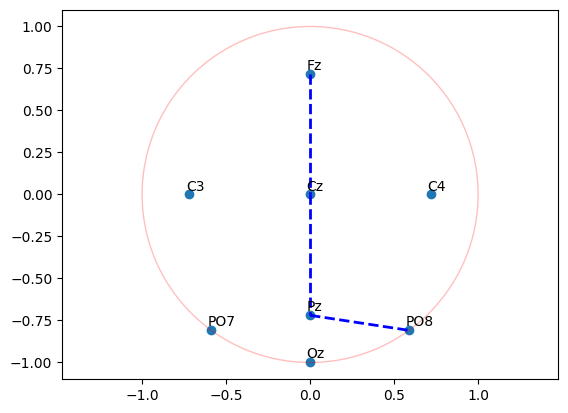

{'Path': ['Fz', 'Cz', 'Pz', 'PO8'], 'Cost': 2.5038175198145947}
Viaje de C3 -> Oz
index :  [1, 4, 6]


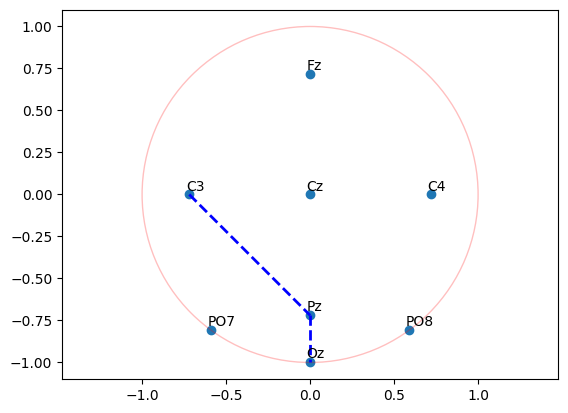

{'Path': ['C3', 'Pz', 'Oz'], 'Cost': 1.7987622885998125}
Viaje de PO7 -> C4
index :  [5, 4, 3]


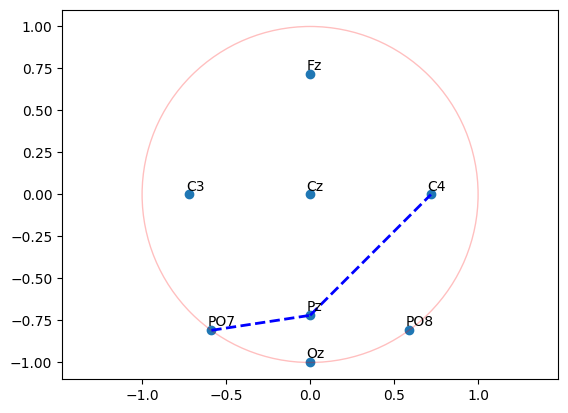

{'Path': ['PO7', 'Pz', 'C4'], 'Cost': 1.9581927327366677}
Viaje de Fz -> C3
index :  [0, 2, 1]


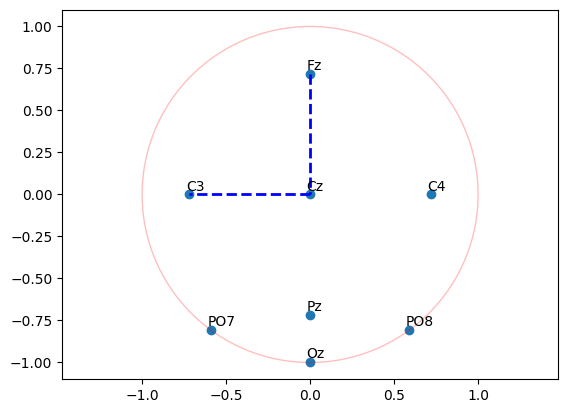

{'Path': ['Fz', 'Cz', 'C3'], 'Cost': 1.562925171035389}
Viaje de PO8 -> Oz
index :  [7, 6]


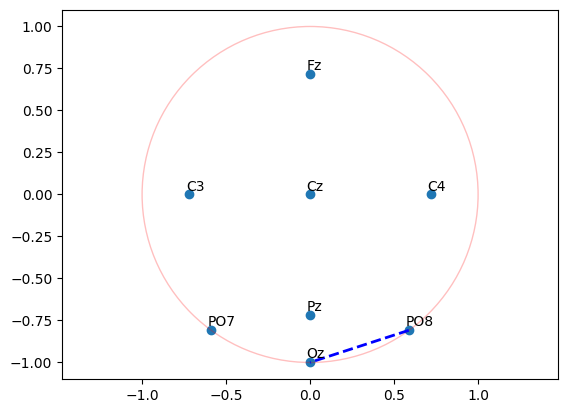

{'Path': ['PO8', 'Oz'], 'Cost': 0.617657422863192}
-----dfs-----
Viaje de Fz -> PO8
index :  [0, 2, 4, 7]


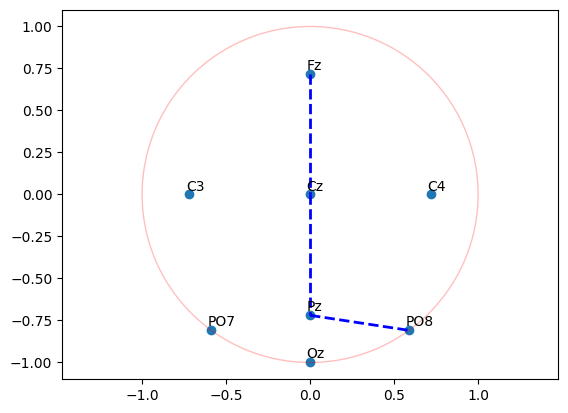

{'Path': ['Fz', 'Cz', 'Pz', 'PO8'], 'Cost': 2.5038175198145947}
Viaje de C3 -> Oz
index :  [1, 5, 7, 6]


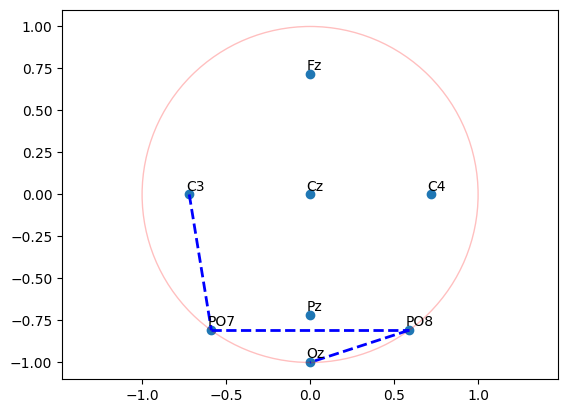

{'Path': ['C3', 'PO7', 'PO8', 'Oz'], 'Cost': 2.8894919349741635}
Viaje de PO7 -> C4
index :  [5, 7, 6, 4, 3]


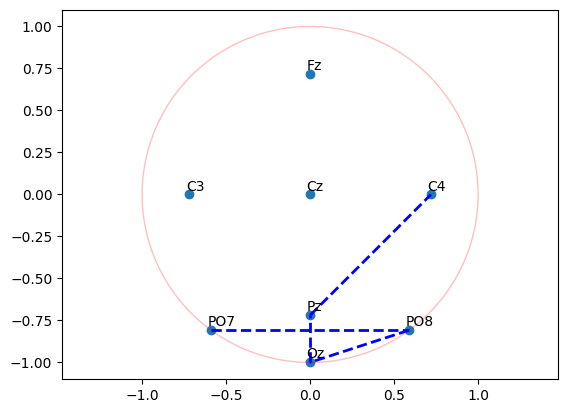

{'Path': ['PO7', 'PO8', 'Oz', 'Pz', 'C4'], 'Cost': 3.591273711463005}
Viaje de Fz -> C3
index :  [0, 2, 4, 7, 6, 5, 1]


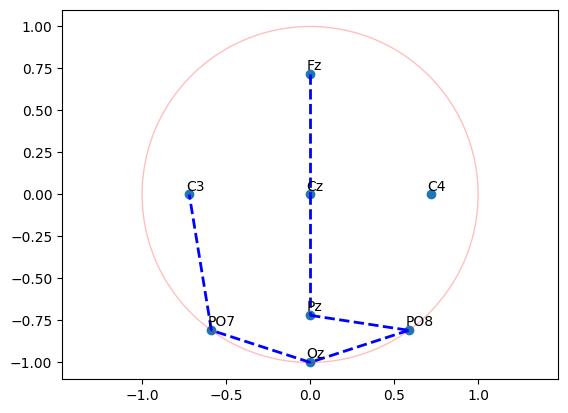

{'Path': ['Fz', 'Cz', 'Pz', 'PO8', 'Oz', 'PO7', 'C3'], 'Cost': 4.83611287765195}
Viaje de PO8 -> Oz
index :  [7, 6]


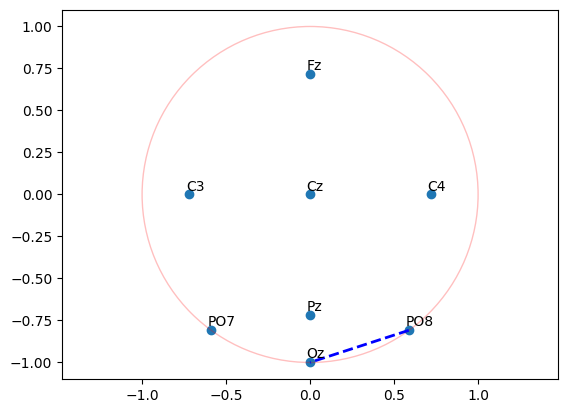

{'Path': ['PO8', 'Oz'], 'Cost': 0.617657422863192}
-----uniform_cost-----
Viaje de Fz -> PO8
index :  [0, 2, 4, 7]


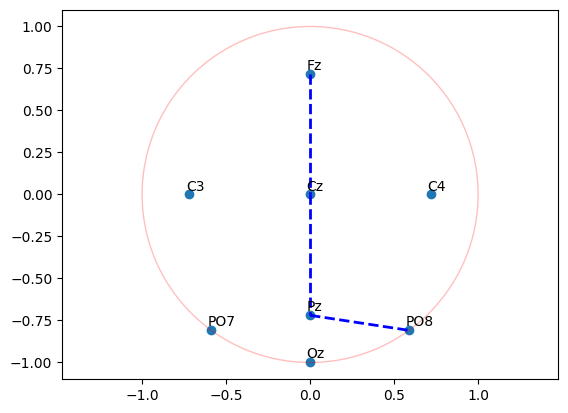

{'Path': ['Fz', 'Cz', 'Pz', 'PO8'], 'Cost': 2.5038175198145947}
Viaje de C3 -> Oz
index :  [1, 5, 6]


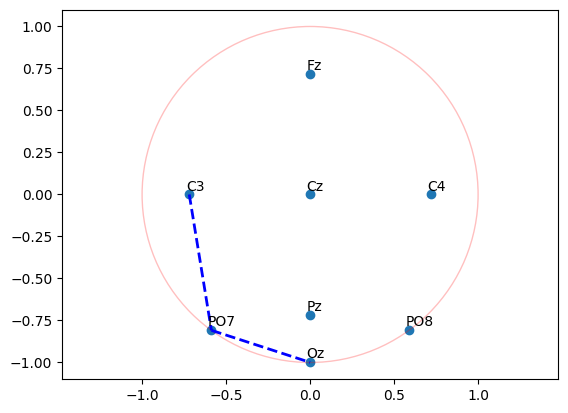

{'Path': ['C3', 'PO7', 'Oz'], 'Cost': 1.7146379349741636}
Viaje de PO7 -> C4
index :  [5, 4, 3]


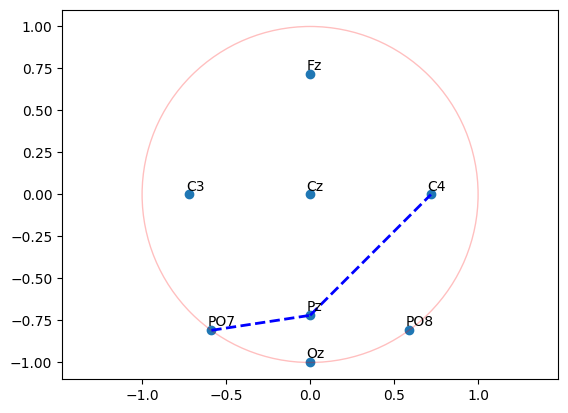

{'Path': ['PO7', 'Pz', 'C4'], 'Cost': 1.9581927327366677}
Viaje de Fz -> C3
index :  [0, 2, 1]


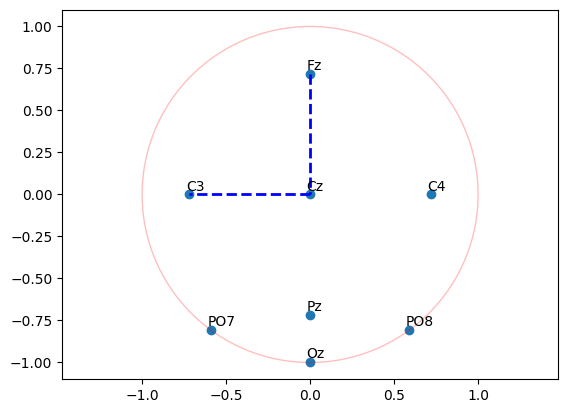

{'Path': ['Fz', 'Cz', 'C3'], 'Cost': 1.562925171035389}
Viaje de PO8 -> Oz
index :  [7, 6]


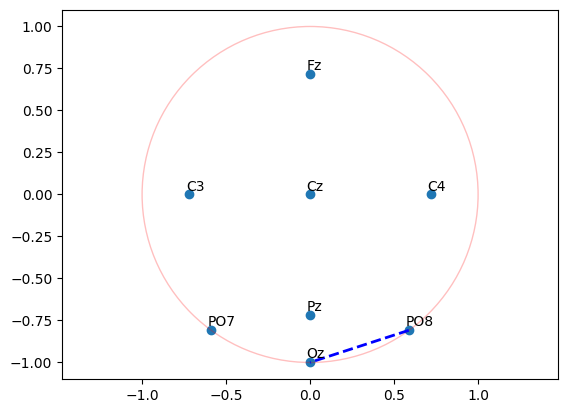

{'Path': ['PO8', 'Oz'], 'Cost': 0.617657422863192}
-----Recorridos de grafos-----
-----bfs-----
Viaje de F7 -> PO4


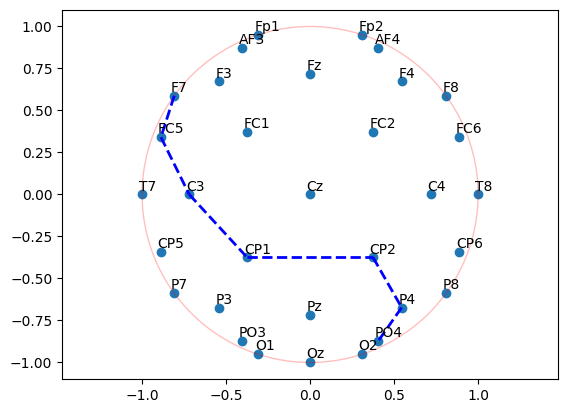

{'Path': ['F7', 'FC5', 'C3', 'CP1', 'CP2', 'P4', 'PO4'], 'Cost': 3.0722100239130095}
Viaje de CP5 -> O2
None
Viaje de P4 -> T7
None
Viaje de AF3 -> CP6


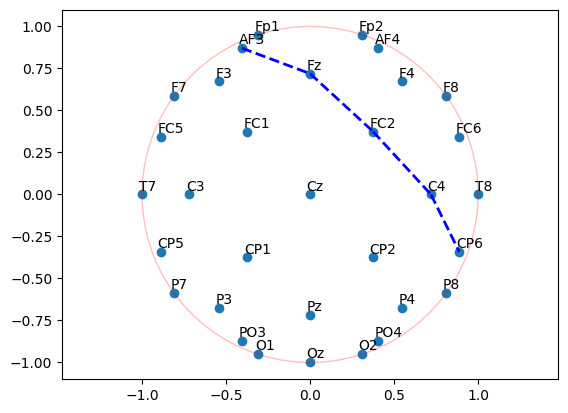

{'Path': ['AF3', 'Fz', 'FC2', 'C4', 'CP6'], 'Cost': 2.208021393484011}
Viaje de F8 -> CP2
None
Viaje de CP1 -> FC2


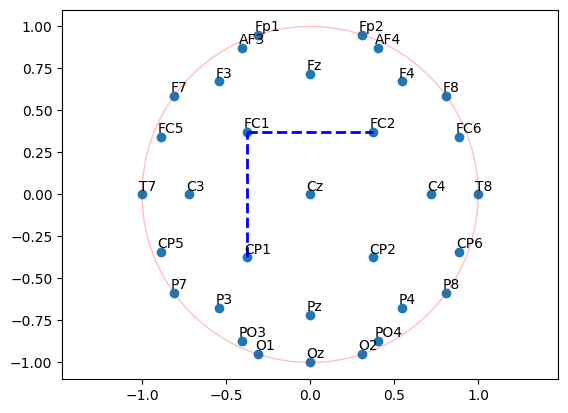

{'Path': ['CP1', 'FC1', 'FC2'], 'Cost': 1.49884}
Viaje de F3 -> O1


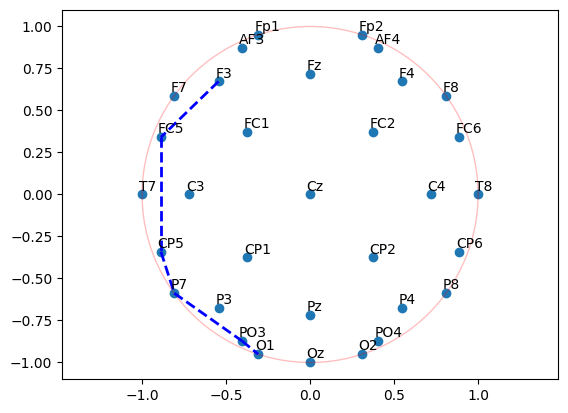

{'Path': ['F3', 'FC5', 'CP5', 'P7', 'PO3', 'O1'], 'Cost': 2.5434489293930467}
-----dfs-----
Viaje de F7 -> PO4


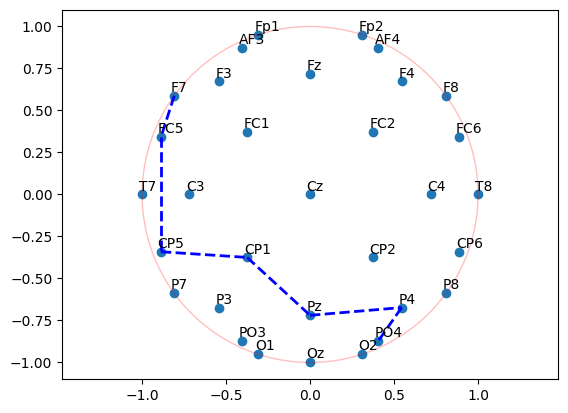

{'Path': ['F7', 'FC5', 'CP5', 'CP1', 'Pz', 'P4', 'PO4'], 'Cost': 3.2994671562982876}
Viaje de CP5 -> O2
None
Viaje de P4 -> T7
None
Viaje de AF3 -> CP6


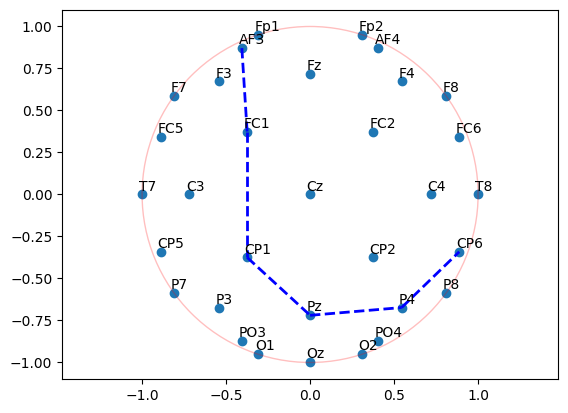

{'Path': ['AF3', 'FC1', 'CP1', 'Pz', 'P4', 'CP6'], 'Cost': 3.1342813297169543}
Viaje de F8 -> CP2
None
Viaje de CP1 -> FC2


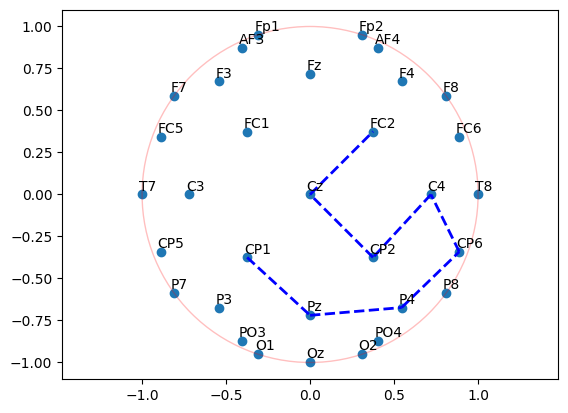

{'Path': ['CP1', 'Pz', 'P4', 'CP6', 'C4', 'CP2', 'Cz', 'FC2'], 'Cost': 3.8022900970741427}
Viaje de F3 -> O1


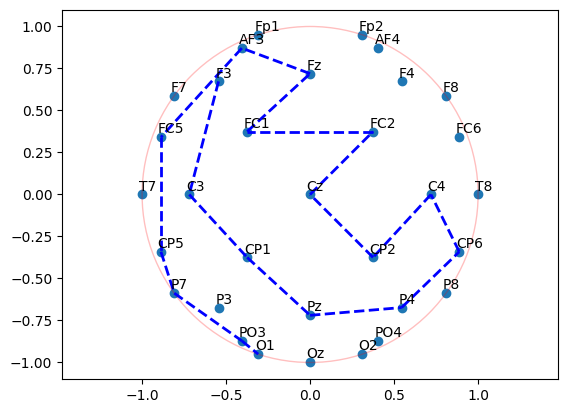

{'Path': ['F3', 'C3', 'CP1', 'Pz', 'P4', 'CP6', 'C4', 'CP2', 'Cz', 'FC2', 'FC1', 'Fz', 'AF3', 'FC5', 'CP5', 'P7', 'PO3', 'O1'], 'Cost': 9.686603252930079}
-----uniform_cost-----
Viaje de F7 -> PO4


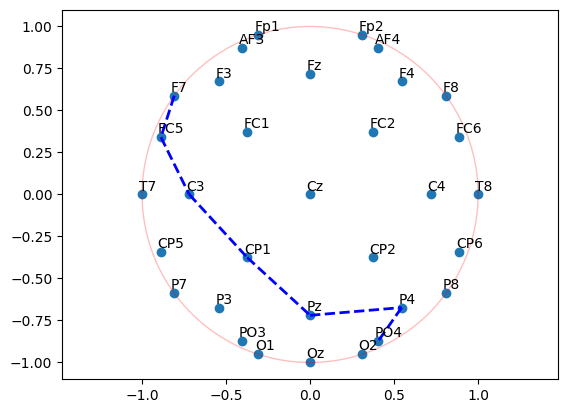

{'Path': ['F7', 'FC5', 'C3', 'CP1', 'Pz', 'P4', 'PO4'], 'Cost': 2.946056211325203}
Viaje de CP5 -> O2
None
Viaje de P4 -> T7
None
Viaje de AF3 -> CP6


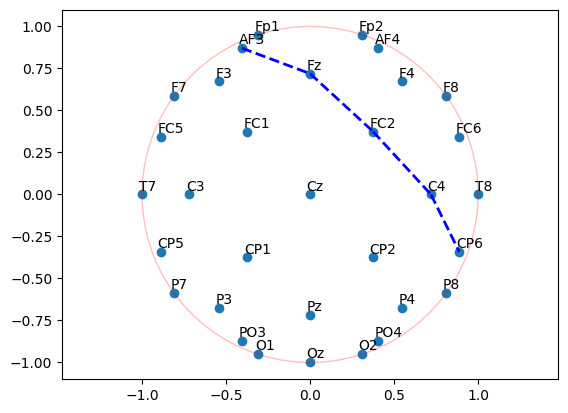

{'Path': ['AF3', 'Fz', 'FC2', 'C4', 'CP6'], 'Cost': 2.208021393484011}
Viaje de F8 -> CP2
None
Viaje de CP1 -> FC2


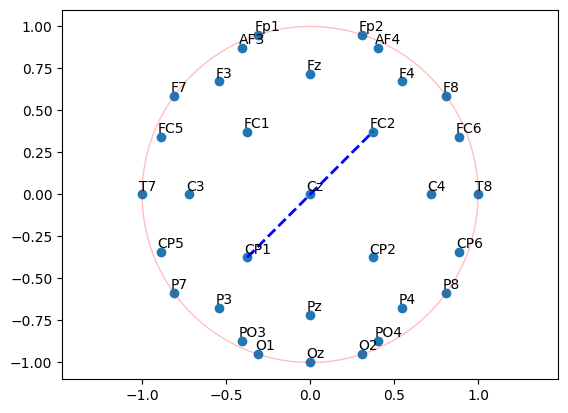

{'Path': ['CP1', 'Cz', 'FC2'], 'Cost': 1.1025508215116433}
Viaje de F3 -> O1


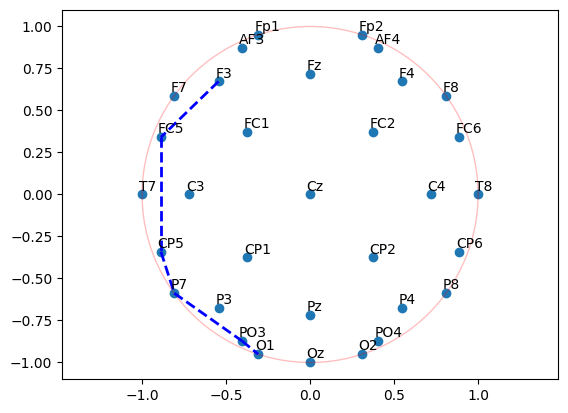

{'Path': ['F3', 'FC5', 'CP5', 'P7', 'PO3', 'O1'], 'Cost': 2.5434489293930467}


In [38]:
#Arreglos para llamar a las funciones

#Arreglo para la busqueda de la matriz de 8 electrodos
array8= [('Fz', 'PO8'), ('C3', 'Oz'), ('PO7', 'C4'), ('Fz', 'C3'), ('PO8', 'Oz')]
#Arreglo para la busqueda de la matriz de 32 electrodos
array32 = [('F7', 'PO4'), ('CP5', 'O2'), ('P4', 'T7'), ('AF3', 'CP6'), ('F8', 'CP2'), ('CP1', 'FC2'), ('F3', 'O1')]

caminosBusquedas(array8, 0, grafo1)

caminosBusquedas(array32, 1, grafo2)

Utilice el método de Floyd para encontrar las distancias mínimas que hay entre todas las parejas de electrodos para todos los grafos.

Clase para hacer el calculo de Floyd-Warshall

In [39]:
class FloydWarshall:
    @staticmethod
    def shortest_paths(adjacency_matrix):
        BIG_NUMBER = 100000000
        n = len(adjacency_matrix)

        matrix = np.array(adjacency_matrix)
        matrix[matrix == 0] = BIG_NUMBER

        for k in range(n):
            for i in range(n):
                for j in range(n):
                    if matrix[i][k] != BIG_NUMBER and matrix[k][j] != BIG_NUMBER and (matrix[i][k] + matrix[k][j]) < matrix[i][j]:
                        matrix[i][j] = matrix[i][k] + matrix[k][j]

        return matrix

In [40]:
grafoFloyd = GraphFloyd(directed=False)
grafoFloyd2 = GraphFloyd(directed=False)

# Matriz de conexion, 0 y 1
grafoFloyd.graficasGraph('Operaciones_Dhali.txt', '8elec.txt')
# graficas('Memoria_Stef.txt', 'mapa8electrodos.txt', grFloyd)
# graficas('Operaciones_Stef.txt', 'mapa8electrodos.txt', grFloyd)

# graficas('LecturaS0A.txt', 'mapa32electrodos.txt', grFloyd)
# graficas('MemoriaS0A.txt', 'mapa32electrodos.txt', grFloyd)
# graficas('OperacionesS0A.txt', 'mapa32electrodos.txt', grFloyd)
grafoFloyd2.graficasGraph('Lectura_S0A.txt', '32elec.txt')

grafoFloydcalc = FloydWarshall()
#Impresión de la matriz de 8 electrodos
print("Length of shortest paths Matriz Floyd")
print(grafoFloydcalc.shortest_paths(grafoFloyd._adjacency_matrix))

#Impresión de la matriz de 32 electrodos
print("Length of shortest paths Matriz Floyd")
print(grafoFloydcalc.shortest_paths(grafoFloyd2._adjacency_matrix))

Operaciones_Dhali.txt
Fz  ->  Cz  edge weight:  0.7814625855176945
C3  ->  Cz  edge weight:  0.7814625855176945
C3  ->  Pz  edge weight:  1.0173003839574621
C3  ->  PO7  edge weight:  1.0969805121109717
Cz  ->  Fz  edge weight:  0.7814625855176945
Cz  ->  C3  edge weight:  0.7814625855176945
Cz  ->  C4  edge weight:  0.7814625855176945
Cz  ->  Pz  edge weight:  0.7814625855176945
C4  ->  Cz  edge weight:  0.7814625855176945
C4  ->  Pz  edge weight:  1.0173003839574621
Pz  ->  C3  edge weight:  1.0173003839574621
Pz  ->  Cz  edge weight:  0.7814625855176945
Pz  ->  C4  edge weight:  1.0173003839574621
Pz  ->  PO7  edge weight:  0.9408923487792055
Pz  ->  Oz  edge weight:  0.7814619046423504
Pz  ->  PO8  edge weight:  0.9408923487792055
PO7  ->  C3  edge weight:  1.0969805121109717
PO7  ->  Pz  edge weight:  0.9408923487792055
PO7  ->  Oz  edge weight:  0.617657422863192
PO7  ->  PO8  edge weight:  1.174854
Oz  ->  Pz  edge weight:  0.7814619046423504
Oz  ->  PO7  edge weight:  0.6176574

Etapa 3 - Análisis de árboles de mínima expansión de los grafos de conectividad

Con los grafos de conectividad no ponderados, encuentra los árboles de mínima expansión por el método que gustes que incluyan la mayor cantidad de vértices posibles.

Función para encontrar los árboles de mínima expansión

In [41]:
def prim(v0, graph=WeightedGraph, newGraph=WeightedGraph):
    cost = 0
    selected = [v0]
    newGraph.add_vertex(v0)
    remain = []
    vnext = None
    padre = None

    for i in graph.vertices():
        if i != v0 and len(graph.adjacent_vertices(i)) > 0:
            remain.append(i)

    while len(remain) > 0:
        minCost = float('inf')
        padre = None
        vnext = None

        for vector in selected:
            vecinos = graph._adjacency_list[vector]

            for vecino in vecinos:
                cn = vecino[1]

                if (cn < minCost and vecino[0] not in selected):
                    padre = vector
                    minCost = cn
                    vnext = vecino[0]

        if (vnext == None):
            print("No hay solucion")
            return None

        newGraph.add_vertex(vnext)
        newGraph.add_edge(padre, vnext, minCost)

        selected.append(vnext)
        remain.remove(vnext)

        cost = cost + minCost

    print(selected, cost)
    return (selected, cost)


#Función para gráficar matrices de 8 electrodos

#Función para gráficar matrices de 32 electrodos



Operaciones_Dhali.txt
Fz  ->  Cz  peso  0.7814625855176945
C3  ->  Cz  peso  0.7814625855176945
C3  ->  Pz  peso  1.0173003839574621
C3  ->  PO7  peso  1.0969805121109717
Cz  ->  Fz  peso  0.7814625855176945
Cz  ->  C3  peso  0.7814625855176945
Cz  ->  C4  peso  0.7814625855176945
Cz  ->  Pz  peso  0.7814625855176945
C4  ->  Cz  peso  0.7814625855176945
C4  ->  Pz  peso  1.0173003839574621
Pz  ->  C3  peso  1.0173003839574621
Pz  ->  Cz  peso  0.7814625855176945
Pz  ->  C4  peso  1.0173003839574621
Pz  ->  PO7  peso  0.9408923487792055
Pz  ->  Oz  peso  0.7814619046423504
Pz  ->  PO8  peso  0.9408923487792055
PO7  ->  C3  peso  1.0969805121109717
PO7  ->  Pz  peso  0.9408923487792055
PO7  ->  Oz  peso  0.617657422863192
PO7  ->  PO8  peso  1.174854
Oz  ->  Pz  peso  0.7814619046423504
Oz  ->  PO7  peso  0.617657422863192
Oz  ->  PO8  peso  0.617657422863192
PO8  ->  Pz  peso  0.9408923487792055
PO8  ->  PO7  peso  1.174854
PO8  ->  Oz  peso  0.617657422863192
Lectura_S0A.txt
Fp1  ->  A

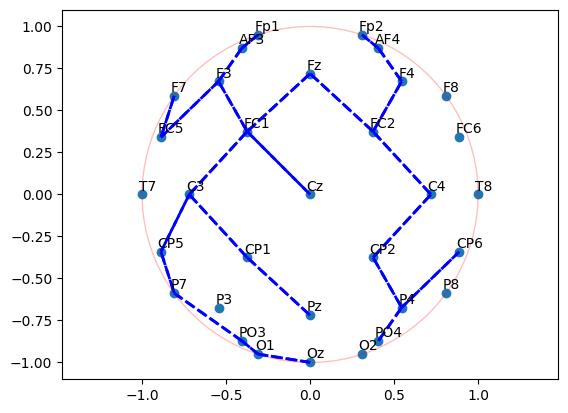

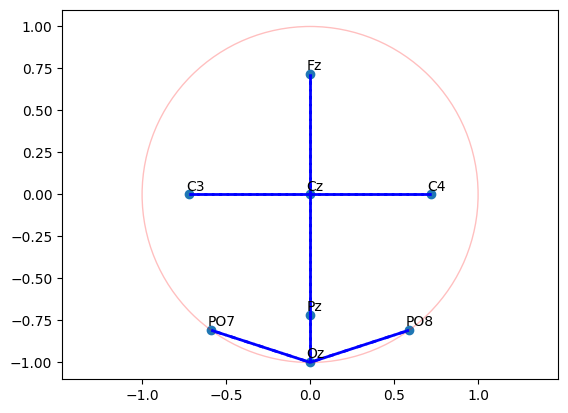

In [42]:
grafoPrim = WeightedGraph(directed=False)

grafoPrim2 = WeightedGraph(directed=False)

# Para prim se tiene que crear una nueva grafica que se llenara con los valores ddel arbol minimo
nuevoGrafo = WeightedGraph(directed=False)
nuevoGrafo2 = WeightedGraph(directed=False)

grafoPrim.graficasGraph('Operaciones_Dhali.txt', '8elec.txt')

grafoPrim2.graficasGraph('Lectura_S0A.txt', '32elec.txt')
# Se envia la funcion el grafico desde donde comenzar, una grafica ya al 100%, y la nueva grafica
prim('Fz', grafoPrim, nuevoGrafo)

prim('Fp1', grafoPrim2, nuevoGrafo2)

print("Grafica madre")
grafoPrim.print_graph()

print("Grafica PRIM")
graficarGrafos("32", nuevoGrafo2)
graficarGrafos("8", nuevoGrafo)

#nuevoGrafo.print_graph()

Etapa 4 - Cascos convexos de los vértices de los árboles de mínima expansión

Para los vértices de cada árbol de expansión mínima, encuentra los cascos convexos que envuelven dichos vértices utilizando cualquier técnica que tengas a tu disposición.

Funciones para calcular los cascos convexos y gráficarlos

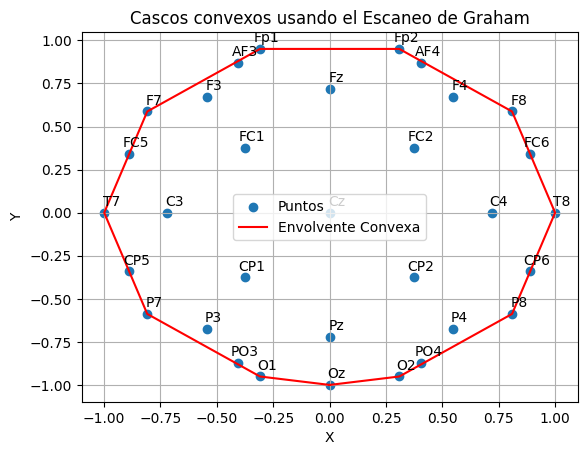

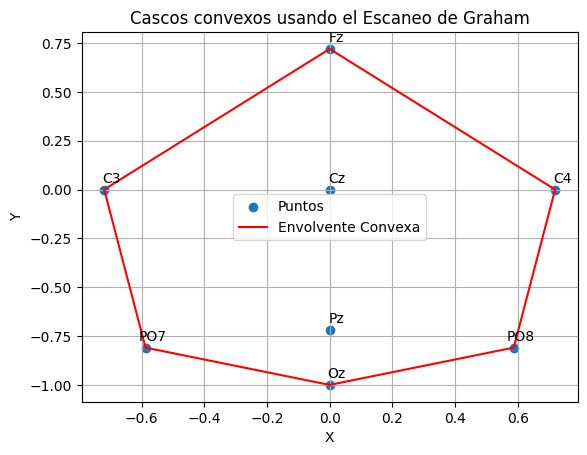

In [46]:
def orientation(p, q, r):
    """
    Determina la orientación entre tres puntos.

    :param p: Primer punto como tupla (x, y).
    :param q: Segundo punto como tupla (x, y).
    :param r: Tercer punto como tupla (x, y).
    :return: 0 si los puntos son colineales, 1 si tienen orientación horaria, 2 si tienen orientación antihoraria.
    """
    val = (q[1] - p[1]) * (r[0] - q[0]) - (q[0] - p[0]) * (r[1] - q[1])
    if val == 0:
        return 0
    return 1 if val > 0 else 2

def graham_scan(points):
    """
    Implementación del algoritmo de Graham para encontrar la envolvente convexa de un conjunto de puntos.

    :param points: Lista de puntos representados como tuplas (x, y).
    :return: Lista de puntos que forman la envolvente convexa.
    """
    n = len(points)
    if n < 3:
        return []

    # Selecciona el punto más bajo (y más a la izquierda) como pivote
    pivot = min(points, key=lambda point: (point[1], point[0]))

    # Ordena los puntos en función de sus ángulos polares con respecto al pivote
    points.sort(key=lambda point: (atan2(point[1] - pivot[1], point[0] - pivot[0]), point))

    hull = [points[0], points[1]]

    for i in range(2, n):
        # Elimina puntos que no contribuyen a la envolvente convexa
        while len(hull) > 1 and orientation(hull[-2], hull[-1], points[i]) != 2:
            hull.pop()
        hull.append(points[i])

    return hull

def plot_convex_hull(mapatxt, hull):
    """
    Grafica los puntos y la envolvente convexa.

    :param mapatxt: Ruta del archivo de coordenadas.
    :param hull: Lista de puntos que forman la envolvente convexa.
    """
    coordenadas = np.loadtxt(mapatxt, dtype=str)
    x = [float(coordenada[1]) for coordenada in coordenadas]
    y = [float(coordenada[2]) for coordenada in coordenadas]
    vertices = [coordenada[0] for coordenada in coordenadas]  # Nombres de los vértices

    convex_x, convex_y = zip(*hull)

    plt.scatter(x, y, marker='o', label='Puntos')
    plt.plot(convex_x + (convex_x[0],), convex_y + (convex_y[0],), linestyle='-', color='red', label='Envolvente Convexa')

    # Agrega etiquetas con los nombres de los vértices junto a cada punto
    for i, vertice in enumerate(vertices):
        plt.annotate(vertice, (x[i], y[i]), textcoords="offset points", xytext=(5,5), ha='center')

    plt.legend()
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title('Cascos convexos usando el Escaneo de Graham')
    plt.grid(True)
    plt.show()

if __name__ == "__main__":
    mapatxt = "32elec.txt"  # Reemplaza con la ruta correcta de tu archivo de coordenadas
    coordenadas = np.loadtxt(mapatxt, dtype=str)
    mapa2txt = "8elec.txt"
    coordenadas2 = np.loadtxt(mapa2txt, dtype=str)

    # Convierte las coordenadas a puntos (x, y)
    puntos = [(float(coordenada[1]), float(coordenada[2])) for coordenada in coordenadas]
    puntos2 = [(float(coordenada2[1]), float(coordenada2[2])) for coordenada2 in coordenadas2]

    # Aplica el algoritmo de Graham para encontrar la envolvente convexa
    convex_hull = graham_scan(puntos)
    convex_hull2 = graham_scan(puntos2)

    # Grafica los puntos y la envolvente convexa
    plot_convex_hull(mapatxt, convex_hull)
    plot_convex_hull(mapa2txt, convex_hull2)

Etapa 5 - Representación del grado de cada arista con diagramas de Voronoi


Función para realizar los calculos voronoi y graficar el diagrama

In [44]:
def voronoi(coordenadastxt, gr=WeightedGraph):
    """
    Genera y grafica un diagrama de Voronoi a partir de las coordenadas de los puntos y colorea las regiones según la cantidad de aristas.

    :param coordenadastxt: Ruta del archivo de coordenadas.
    :param gr: Grafo ponderado para obtener información sobre las aristas (predeterminado: WeightedGraph).
    """
    # Carga las coordenadas y nombres desde el archivo
    coordenadas = np.loadtxt(coordenadastxt, dtype=float, usecols=(1, 2))
    nombres = np.loadtxt(coordenadastxt, dtype=str, usecols=(0))

    # Calcula la cantidad de aristas para cada punto
    aristas = [len(gr.adjacent_vertices(nombre)) for nombre in nombres]

    # Genera la teselación de Voronoi
    vor = Voronoi(coordenadas)

    # Encuentra los valores mínimo y máximo para la normalización
    minima = min(aristas)
    maxima = max(aristas)

    # Normaliza el mapa de colores elegido
    norm = mpl.colors.Normalize(vmin=minima, vmax=maxima, clip=True)
    mapper = cm.ScalarMappable(norm=norm, cmap=cm.Blues_r)

    # Grafica el diagrama de Voronoi y colorea las regiones finitas según el valor de aristas
    voronoi_plot_2d(vor, show_points=True, show_vertices=False, s=1)

    for r in range(len(vor.point_region)):
        region = vor.regions[vor.point_region[r]]
        if not -1 in region:
            polygon = [vor.vertices[i] for i in region]
            plt.fill(*zip(*polygon), color=mapper.to_rgba(aristas[r]))

    plt.show()

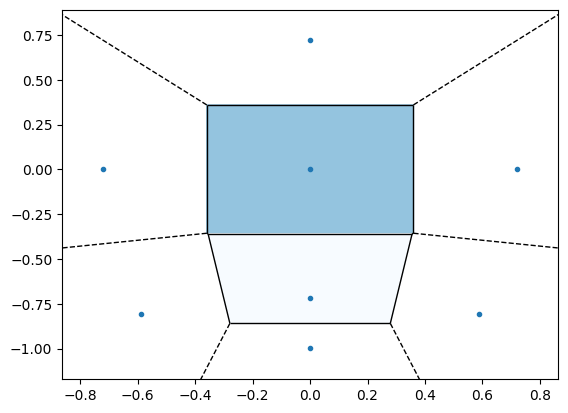

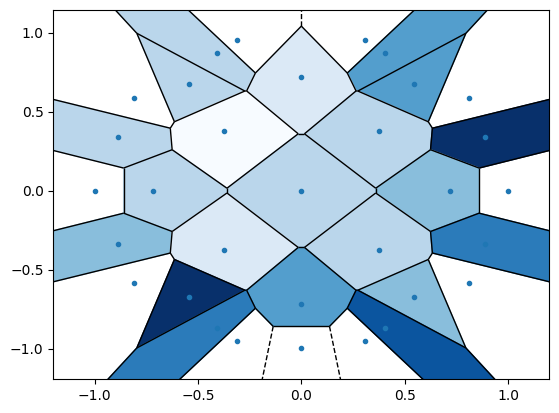

In [45]:
#Llamada a función con la matriz de 8 electrodos
voronoi('8elec.txt', grafo1)

#Llamada a función con la matriz de 8 electrodos
voronoi('32elec.txt', grafo2)